In this tutorial, we will simulate a naive model of a micrograph. In particular, we will simulate a batch of images of the same particle at random poses, then sum over them.

The goal of this tutorial is to learn how to vmap in `cryojax`'s recommended pattern, which is using `equinox`.

In [1]:
# Jax imports
import jax
import jax.numpy as jnp
import numpy as np

In [2]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
# CryoJAX imports
import cryojax.simulator as cxs
from cryojax.io import read_array_with_spacing_from_mrc
from cryojax.rotations import SO3

First, we will build the image formation modeling components that we do not want to vmap over.

In [ ]:
# First, load the scattering potential and projection method
filename = "./data/groel_5w0s_scattering_potential.mrc"
real_voxel_grid, voxel_size = read_array_with_spacing_from_mrc(filename)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)
# ... now the projection method
potential_integrator = cxs.FourierSliceExtraction()
# ... and the contrast transfer theory
transfer_theory = cxs.ContrastTransferTheory(
    ctf=cxs.AberratedAstigmaticCTF(
        defocus_in_angstroms=10000.0,
        astigmatism_in_angstroms=0.0,
    )
)
# ... finally, the instrument_config
shape = (400, 600)
pixel_size = potential.voxel_size  # Angstroms
voltage_in_kilovolts = 300.0
instrument_config = cxs.InstrumentConfig(
    shape, pixel_size, voltage_in_kilovolts, pad_scale=1.1
)
image_size = np.asarray(shape) * pixel_size

Now we will construct a `ContrastImageModel` by batching over a set of random number generator keys.

In [ ]:
from functools import partial

import equinox as eqx
from jaxtyping import PRNGKeyArray, PyTree

from cryojax.jax_util import get_filter_spec


@partial(eqx.filter_vmap, in_axes=(0, None), out_axes=(0, None))
def make_image_model(
    key: PRNGKeyArray, no_vmap: tuple[PyTree, ...]
) -> tuple[cxs.ContrastImageModel, cxs.ContrastImageModel]:
    config, potential, potential_integrator = no_vmap
    # ... instantiate rotations
    rotation = SO3.sample_uniform(key)
    # ... now in-plane translation
    ny, nx = config.shape
    offset_in_angstroms = (
        jax.random.uniform(key, (2,), minval=-0.45, maxval=0.45)
        * jnp.asarray((nx, ny))
        * config.pixel_size
    )
    # ... build the pose
    pose = cxs.QuaternionPose.from_rotation_and_translation(rotation, offset_in_angstroms)
    # ... build the ensemble
    structural_ensemble = cxs.SingleStructureEnsemble(potential, pose)
    # ... and finally the scattering theory and the imaging pipeline
    theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble, potential_integrator, transfer_theory
    )
    image_model = cxs.ContrastImageModel(config, theory)
    # ... now, for some vmap considerations. first, specify which leaves we would
    # like to broadcast over
    where = lambda p: p.scattering_theory.structural_ensemble.pose
    # ... use a cryojax wrapper to return a "filter_spec", a concept in `equinox`
    # for performing what are called "filtered transformations"
    filter_spec = get_filter_spec(image_model, where)
    # ... split up the `image_model` into broadcasted and non-broadcasted
    # parts
    image_model_vmap, image_model_novmap = eqx.partition(image_model, filter_spec)
    return image_model_vmap, image_model_novmap

!!! info "What does `eqx.partition` do?"
    
    JAX transformations typically require grouping pytree leaves into different categories. `jax.jit` makes the distinction between traced and static arguments, `jax.vmap` has broadcasted and non-broadcasted arguments, and of course `jax.grad` has differentiated and non-differentiated. `equinox` makes grouping leaves more elegant with the concept of *filtered transformations*. In this example, we use a `cryojax` utility to create what is called a `filter_spec`, which is a pytree of booleans of the same structure as `image_model`. The values are `True` at leaves specified by `where` and `False` otherwise. Then, `equinox.partition` is used to split up the pytree into broadcasted and non-broadcasted arguments. Filtered transformations are a cornerstone to `equinox` and it is highly recommended to learn about them. See [here](https://docs.kidger.site/equinox/examples/frozen_layer/) in the equinox documentation for reading.

!!! info "Why do we set `out_axes=(0, None)`?"
    
    When we create a pytree with `eqx.filter_vmap` (or `jax.vmap`), `out_axes` should be a prefix output pytree. If `out_axes` is set to `None` at a particular leaf, this
    says that we do not want to broadcast that leaf (of course, this only works for unmapped leaves). By default `jax.vmap` sets `out_axes=0`, so all unmapped leaves get broadcasted. Typically, we only want to broadcast leaves in `cryojax` functions that are directly mapped, so we must set the `out_axes` value at those leaves to `None`.

In [ ]:
# Generate RNG keys
number_of_poses = 20
keys = jax.random.split(jax.random.key(12345), number_of_poses)

# ... instantiate the instrument_pipeline
image_model_vmap, image_model_novmap = make_image_model(
    keys, (instrument_config, potential, potential_integrator)
)
# ... inspect the objects
print(image_model_vmap)

ContrastImagingPipeline(
  instrument_config=InstrumentConfig(
    shape=(None, None),
    pixel_size=None,
    voltage_in_kilovolts=None,
    electrons_per_angstrom_squared=None,
    padded_shape=(None, None),
    pad_mode=None
  ),
  scattering_theory=WeakPhaseScatteringTheory(
    structural_ensemble=SingleStructureEnsemble(
      potential=FourierVoxelGridPotential(
        fourier_voxel_grid=None,
        frequency_slice_in_pixels=None,
        voxel_size=None
      ),
      pose=QuaternionPose(
        offset_x_in_angstroms=f32[20],
        offset_y_in_angstroms=f32[20],
        wxyz=f32[20,4]
      ),
      conformation=None
    ),
    potential_integrator=FourierSliceExtraction(
      pixel_rescaling_method=None,
      interpolation_order=None,
      interpolation_mode=None,
      interpolation_cval=None
    ),
    transfer_theory=ContrastTransferTheory(
      ctf=AberratedAstigmaticCTF(
        defocus_in_angstroms=None,
        astigmatism_in_angstroms=None,
        astigmati

This may be a little odd at first. We have contructed `ContrastImageModel`s, where if we were to directly call their `render` method, we would get an error. Some arguments are broadcasted and others are `None` Think of it this way: because we created our `image_model`s with a `vmap`, functions can now only be called after crossing `vmap` boundaries. There is very good reason for this! To learn more, read the section of the equinox documentation on [model ensembling](https://docs.kidger.site/equinox/tricks/#ensembling).

Finally, we can define functions to batch and sum over images! To do this, we will complete the picture of how to use `equinox` filtered transformations by demonstrating `eqx.combine`. This function recombines a partitioned pytree, allowing us to smoothly pass over a `vmap` boundary.

In [ ]:
import equinox as eqx


@partial(eqx.filter_vmap, in_axes=(0, None))
def compute_image_stack(image_model_vmap, image_model_novmap):
    """Compute a batch of images at different poses."""
    image_model = eqx.combine(image_model_vmap, image_model_novmap)
    return image_model.render()


@eqx.filter_jit
def compute_micrograph(image_model_vmap, image_model_novmap):
    """Sum together the image stack."""
    return jnp.sum(compute_image_stack(image_model_vmap, image_model_novmap), axis=0)

(<Figure size 550x550 with 2 Axes>,
 <Axes: title={'center': 'Image contrast for a sum of random poses'}>)

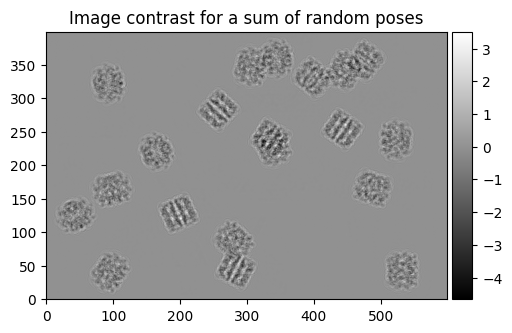

In [ ]:
# Compute the image and plot
fig, ax = plt.subplots(figsize=(5.5, 5.5))
micrograph = compute_micrograph(image_model_vmap, image_model_novmap)
plot_image(
    micrograph,
    fig,
    ax,
    label="Image contrast for a sum of random poses",
    interpolation=None,
)

**What next?**

It is highly recommended to learn about about [pytree manipulation](https://docs.kidger.site/equinox/api/manipulation/) in equinox. In particular, read more about [eqx.partition and eqx.combine](https://docs.kidger.site/equinox/api/manipulation/#equinox.partition). This thread on the `equinox` github may also be useful: [https://github.com/patrick-kidger/equinox/issues/618](https://github.com/patrick-kidger/equinox/issues/618).